# Setup

In [24]:
!pip install -q tf-models-official==2.3.0
!pip install transformers

     |████████████████████████████████| 849kB 15.8MB/s 
     |████████████████████████████████| 102kB 14.6MB/s 
     |████████████████████████████████| 174kB 24.9MB/s 
     |████████████████████████████████| 358kB 50.6MB/s 
     |████████████████████████████████| 1.2MB 58.4MB/s 
     |████████████████████████████████| 37.6MB 80kB/s 
     |████████████████████████████████| 1.8MB 21.4MB/s 
     |████████████████████████████████| 890kB 54.5MB/s 
     |████████████████████████████████| 2.9MB 46.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=6113fd10159a71d6b7c5c943e1b2f9f87008107629c7350f77036d0c869f1037
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [25]:
import os
import json

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

This directory contains the configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:

# Dataset

In [26]:
# import sys
# !git clone "https://github.com/giuliofortini/NLP_SQuAD_Project"
# sys.path.append("NLP_SQuAD_Project/")

from google.colab import files
try:
  with open('training_set.json') as f:
    json_data = json.load(f)
except:
  from google.colab import drive
  drive.mount('/content/drive')
  with open('/content/drive/My Drive/SQUAD/training_set.json') as f:
    json_data = json.load(f)

Mounted at /content/drive


In [27]:
data = pd.json_normalize(json_data['data'])
data

,title,paragraphs
0,University_of_Notre_Dame,"[{'context': 'Architecturally, the school has ..."
1,Beyoncé,[{'context': 'Beyoncé Giselle Knowles-Carter (...
2,Montana,[{'context': 'Montana i/mɒnˈtænə/ is a state i...
3,Genocide,"[{'context': 'The phrase ""in whole or in part""..."
4,Antibiotics,[{'context': 'The emergence of resistance of b...
...,...,...
437,Police,[{'context': 'A police force is a constituted ...
438,"Punjab,_Pakistan","[{'context': 'Punjab (Urdu, Punjabi: پنجاب, pa..."
439,Infection,[{'context': ' Among the vast varieties of mic...
440,Hunting,[{'context': 'Hunting is the practice of killi...


In [28]:
train, test = train_test_split(data, test_size=0.2)

In [29]:
def preprocess_df(df):
  temp = []
  title_dict = {}
  contexts = []

  for i, row in df.iterrows():
    for context in row['paragraphs']:
      contexts.append(context['context'])
      for qa in context['qas']:
        question_id = qa['id']
        question = qa['question']
        for answer in qa['answers']:
          answer_text = answer['text']
          answer_start = answer['answer_start']
          answer_end = answer_start+len(answer_text)
          temp.append([question_id, question, answer_text, answer_start, answer_end, i, len(contexts)-1])


  context_dict = dict(enumerate(contexts))

  df = pd.DataFrame(temp, columns=['question_id', 'question_text', 'answer_text', 'answer_start', 'answer_end', 'title_id', 'context_id'])
  
  return df, context_dict

train_df, train_context_dict = preprocess_df(train)
test_df, test_context_dict = preprocess_df(test)

In [30]:
train_df

,question_id,question_text,answer_text,answer_start,answer_end,title_id,context_id
0,570a58de6d058f1900182d7a,What system of the body is related to emotion'...,nervous,220,227,133,0
1,570a58de6d058f1900182d7b,What sorts of people are more likely to be emo...,Extroverted,373,384,133,0
2,570a58de6d058f1900182d7c,What type of people hide their emotions?,introverted,455,466,133,0
3,570a58de6d058f1900182d7d,What is emotion frequently responsible for dri...,motivation,590,600,133,0
4,570a58de6d058f1900182d7e,"Along with physical changes, what sort of chan...",psychological,107,120,133,0
...,...,...,...,...,...,...,...
67577,56e7b5cf00c9c71400d77546,"In 2008, what was the average attendance for a...","12,957",531,537,70,14693
67578,56e7b5cf00c9c71400d77547,"During the 2008 season, how many teams average...",eight,544,549,70,14693
67579,56e7b60637bdd419002c43c2,What was the AFL's average per-game attendance...,"8,135",118,123,70,14694
67580,56e7b60637bdd419002c43c3,"In the 2010 season, how many teams drew an ave...",one,135,138,70,14694


In [31]:
import random
def print_squad_sample(train_data, context_dict, line_length=120, separator_length=150):
  sample = train_data.sample(frac=1).head(1)
  context = context_dict[sample['context_id'].item()]
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [''.join(context[idx:idx+line_length]) for idx in range(0, len(context), line_length)]
  for l in lines:
      print(l)
  #print(context)
  print('='*separator_length)
  questions = train_data[train_data['context_id'] == sample['context_id'].item()]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), answer)

print_squad_sample(train_df, train_context_dict)

CONTEXT: 
With the gradual weakening of the Marathas in the aftermath of the three Anglo-Maratha wars, the British also secured th
e Ganges-Jumna Doab, the Delhi-Agra region, parts of Bundelkhand, Broach, some districts of Gujarat, the fort of Ahmmadn
agar, province of Cuttack (which included Mughalbandi/the coastal part of Odisha, Garjat/the princely states of Odisha, 
Balasore Port, parts of Midnapore district of West Bengal), Bombay (Mumbai) and the surrounding areas, leading to a form
al end of the Maratha empire and firm establishment of the British East India Company in India.
QUESTION:                                                                                                                  ANSWER:
how many Anglo Maratha wars were there?                                                                                    three
What empire ended after the three Anglo- Maratha wars?                                                                     Maratha empire
With the for

# Encoding

#Tokenizer

In [32]:
from transformers import BertTokenizer, BertModel

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print('[[CLS], [SEP]] = {}'.format(tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])))


[[CLS], [SEP]] = [101, 102]


In [35]:
# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(train_df['question_text'][0])

# Print out the tokens.
print(tokenized_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6}'.format(tup[0], tup[1]))

['what', 'system', 'of', 'the', 'body', 'is', 'related', 'to', 'emotion', "'", 's', 'physiology', '?']
what           2054
system         2291
of             1997
the            1996
body           2303
is             2003
related        3141
to             2000
emotion        7603
'              1005
s              1055
physiology    16127
?              1029


In [36]:
# hyperparams
SEQUENCE_LIMIT = 512
STRIDE = 256

In [151]:
a = tf.convert_to_tensor(np.array(list(range(100))))
b = list(range(32, 50))

def find_sublist(a, b):
  if len(a) == 0 or len(b) == 0:
    raise Exception("AAAAAAA")

  found = False
  for i in range(len(a) - len(b) +1):
    if np.array_equal(a[i:i+len(b)], b):
      return i, i+len(b)-1

  return -1, -1

find_sublist(a, b)

(32, 49)

In [199]:
def print_progress(value, total, bar_width=100):
  perc = int(value/total*bar_width)
  rest = bar_width - perc
  print(f"\r{perc} % [ {perc*'■'}{rest*'─'} ]", end="")

# ensure to preserve all sub-sequences of length limi-stride. 
def split_long_sequence(my_sequence, limit, stride):

  if len(my_sequence) <= limit: 
    return [my_sequence]
  
  rest = my_sequence
  split = []
  while len(rest) > limit:
    left_hand = rest[:limit]
    rest = rest[stride:]
    split.append(left_hand)
    
  split.append(rest)
  return split 

In [218]:
def from_df_to_model_dict(df, context_dict, verbose=False):

  # initialize structures
  input_ids = []
  input_mask = []
  input_type_ids = []
  start_indexes = []
  end_indexes = []

  cut_counter = 0
  max_iter = len(df)
  new_entries = 0
  for i, row in df.iterrows():

    # print progress
    if (i+1) % (max_iter // 100) == 0 or i == 0:
      # perc = int(i/max_iter*100)+1
      # rest = 100 - perc
      # print(f"\r{perc} % [ {perc*'■'}{rest*'─'} ]", end="")
      print_progress(i+1, max_iter)

    # encode question and context
    if verbose: print("\tTokenizing question and context...", end="")
    encoded_question = tokenizer.encode(row['question_text'])
    encoded_context = tokenizer.encode(context_dict[row['context_id']])[1:]

    # concatenate input data 
    #encoded_input = encoded_question + encoded_context
    if verbose: print("\tChecking sequence length...")
    if len(encoded_question + encoded_context) > SEQUENCE_LIMIT:
      # if the sequence is too long, split it in n subsequences of length <= SEQUENCE_LIMIT
      encoded_contexts = split_long_sequence(encoded_context,
                                             limit=SEQUENCE_LIMIT-len(encoded_question), 
                                             stride=STRIDE)

      cut_counter += 1
    else:
      encoded_contexts = [encoded_context]
    
    new_entries += len(encoded_contexts)-1
    # for each too long sequence, the context has been split in n parts. We need to process them separately, creating new entries for the input
    for context in encoded_contexts:
      
      encoded_input = encoded_question + context      

      # create mask of ones
      ones_mask = tf.ones_like(encoded_input)

      # add padding and convert to tensor
      if verbose: print("\tPadding...", end="")
      encoded_input = tf.keras.preprocessing.sequence.pad_sequences([encoded_input], maxlen=512, padding='pre')
      encoded_input = tf.squeeze(tf.convert_to_tensor(encoded_input))
      # processing answer indices
      #print("\tProcessing answer...")
      tokenized_answer = tokenizer.encode(row['answer_text'])[1: -1]
      # try:
      #   start_idx = encoded_input[tokenized_answer][0]
      #   end_idx = start_idx + len(tokenized_answer)
      # except ValueError:
      #   start_idx = -1
      #   end_idx = -1
      start_idx, end_idx = find_sublist(encoded_input, tokenized_answer)
      # print(encoded_input)
      # print(tokenized_answer)
      # print((start_idx, end_idx))
      start_indexes.append(start_idx)
      end_indexes.append(end_idx)


      # create input_type_ids
      if verbose: print("\tInput types creation...", end="")
      type_ids = tf.concat([tf.zeros_like(encoded_question, dtype=tf.int32), 
                            tf.ones_like(encoded_context, dtype=tf.int32)], 
                          axis=-1)

      type_ids = tf.keras.preprocessing.sequence.pad_sequences([type_ids], maxlen=512, padding='pre')
      type_ids = tf.squeeze(tf.convert_to_tensor(type_ids))


      # create mask of zeros
      if verbose: print("\tMask creation...", end="")
      # zeros_mask = tf.zeros_like(tf.shape(encoded_question)[-1]-tf.shape(ones_mask)[-1], dtype=tf.int32)
      zeros_mask = tf.zeros(SEQUENCE_LIMIT - len(ones_mask), dtype=tf.int32)
      mask = tf.concat([zeros_mask, ones_mask], axis=-1)

      # append elements to lists
      if verbose: print("\tAppending inputs...", end="")
      input_ids.append(encoded_input)
      input_mask.append(mask)
      input_type_ids.append(type_ids)

  # save input data as dictionary
  inputs = {
    'input_ids': tf.convert_to_tensor(input_ids),
    'attention_mask': tf.convert_to_tensor(input_mask),
    'token_type_ids': tf.convert_to_tensor(input_type_ids)
    }

  assert len(input_ids) == len(df) + new_entries, f"DIOCANE:\nci sono {len(input_ids)} input_ids, MA {len(df)} righe nel df e {new_entries} nuove entries 8===D"
  return inputs, start_indexes, end_indexes

In [287]:
print("Building training set...", end=" ")
train_inputs, train_starts, train_ends = from_df_to_model_dict(train_df[:1000], train_context_dict)
print("done.")

print("Building test set...", end=" ")
test_inputs, test_starts, test_ends = from_df_to_model_dict(test_df[:1000], test_context_dict)
print("done.")

100 % [ ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ]367 367
392 394
408 409
431 431
349 349
399 401
405 405
429 429
496 496
424 424


In [289]:
print(train_inputs['input_ids'][0])
print(train_inputs['attention_mask'][0])
print(train_inputs['token_type_ids'][0])

tf.Tensor(
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [223]:
# longest answer
for col in ["question_text", "answer_text"]:
  max_len = 0
  for text in train_df[col]:
    length = len(tokenizer.encode(text))
    max_len = max(length, max_len)
  print(f"Max length for tokenized {col}: {max_len}")

## Build model

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls', 'bert/encoder/layer_._8/intermediate/dense/bias:0', 'bert/encoder/layer_._6/output/dense/kernel:0', 'bert/encoder/layer_._0/attention/output/dense/kernel:0', 'bert/encoder/layer_._6/attention/self/value/kernel:0', 'bert/encoder/layer_._7/output/LayerNorm/beta:0', 'bert/encoder/layer_._0/output/LayerNorm/gamma:0', 'bert/encoder/layer_._3/attention/self/value/bias:0', 'bert/encoder/layer_._7/attention/self/value/bias:0', 'bert/encoder/layer_._1/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._1/attention/self/value/bias:0', 'bert/encoder/layer_._4/attention/output/dense/kernel:0', 'bert/encoder/layer_._8/attention/self/key/bias:0', 'bert/encoder/layer_._9/attention/output/LayerNorm/gamma:0', 'bert/encoder/layer_._5/attention/self/key/bias:0', 'bert/encoder/layer_._11/attention/output/LayerNorm/gamma:0', 'bert/encoder/layer_._2/attention/self/key/kern

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_87 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_88 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_89 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_36 (TFBertModel)  TFBaseModelOutputWit 109482240   input_87[0][0]                   
                                                                 input_88[0][0]            

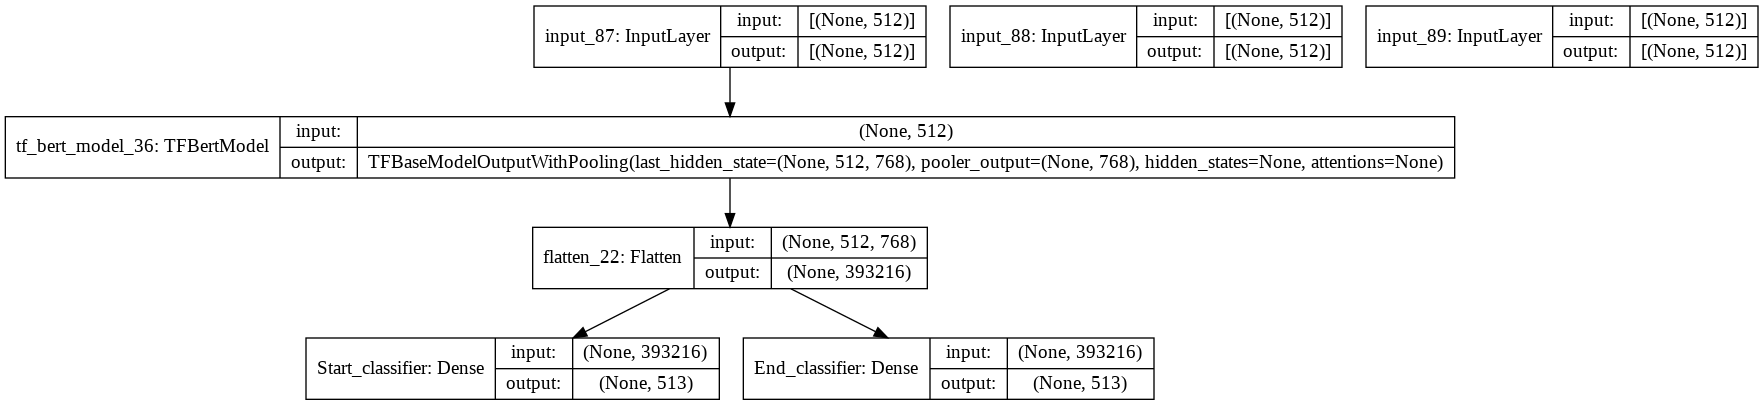

In [290]:
from keras import Model
from keras.utils import plot_model
from keras.layers import Input, Dense, Flatten, Concatenate
from transformers import TFBertModel


output_dim = SEQUENCE_LIMIT + 1 # add one class for non-found answers

input_ids_layer = Input(shape = (512,), dtype='int64')
attention_mask_layer = Input(shape = (512,), dtype='int64')
token_ids_layer = Input(shape = (512,), dtype='int64')

bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_model.trainable = False
bert = bert_model(input_ids=input_ids_layer, attention_mask = attention_mask_layer, token_type_ids=token_ids_layer).last_hidden_state

flat = Flatten()(bert)
start_classifier = Dense(units=output_dim, activation="softmax", name="Start_classifier")(flat)
end_classifier = Dense(units=output_dim, activation="softmax", name="End_classifier")(flat)

model = Model(inputs=[input_ids_layer, attention_mask_layer, token_ids_layer], 
              outputs=[start_classifier, end_classifier])
model.summary()
plot_model(model, show_shapes=True)

In [284]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [285]:
y_starts = tf.keras.utils.to_categorical([val if val != -1 else 512 for val in train_starts])
y_ends = tf.keras.utils.to_categorical([val if val != -1 else 512 for val in train_ends])

In [286]:
model_fit = model.fit(x = [train_inputs['input_ids'],
                           train_inputs['attention_mask'],
                           train_inputs['token_type_ids']],
                      y = [y_starts,
                           y_ends],
                       
                      batch_size=32, epochs=4, 
                      )#validation_data=(validation_input_ids, validation_label)
                   


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/4


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


32/32 [==============================] - 62s 2s/step - loss: 38.3193 - Start_classifier_loss: 19.2781 - End_classifier_loss: 19.0412 - Start_classifier_accuracy: 0.0101 - End_classifier_accuracy: 0.0084
Epoch 2/4
32/32 [==============================] - 53s 2s/step - loss: 20.6514 - Start_classifier_loss: 10.3916 - End_classifier_loss: 10.2599 - Start_classifier_accuracy: 0.0633 - End_classifier_accuracy: 0.0577
Epoch 3/4
32/32 [==============================] - 53s 2s/step - loss: 16.4435 - Start_classifier_loss: 8.0980 - End_classifier_loss: 8.3455 - Start_classifier_accuracy: 0.1269 - End_classifier_accuracy: 0.1122
Epoch 4/4
32/32 [==============================] - 53s 2s/step - loss: 15.5764 - Start_classifier_loss: 7.6481 - End_classifier_loss: 7.9283 - Start_classifier_accuracy: 0.1948 - End_classifier_accuracy: 0.1799


Batch: 1/312
Batch: 2/312
Batch: 3/312
Batch: 4/312
Batch: 5/312
Batch: 6/312
Batch: 7/312
Batch: 8/312
Batch: 9/312
Batch: 10/312
Batch: 11/312
Batch: 12/312
Batch: 13/312
Batch: 14/312
Batch: 15/312
Batch: 16/312
Batch: 17/312
Batch: 18/312
Batch: 19/312
Batch: 20/312
Batch: 21/312
Batch: 22/312
Batch: 23/312
Batch: 24/312
Batch: 25/312
Batch: 26/312
Batch: 27/312
Batch: 28/312
Batch: 29/312
Batch: 30/312
Batch: 31/312


In [ ]:
print(test_answers[0].last_hidden_state)

tf.Tensor(
[[[-0.4465253   0.48536447  0.06580014 ... -0.46521625  0.41014314
   -0.70420337]
  [-0.6818489  -0.2513821   0.5476869  ... -0.3495175   0.79528636
   -0.9575961 ]
  [-0.33148208  0.00827573  0.59227216 ... -0.5239812   0.08607539
   -1.0944345 ]
  ...
  [-1.0840538   0.35074574  0.7235429  ...  0.43597403  0.7232471
   -0.30706415]
  [-0.08872701 -1.2204639   1.1156192  ... -0.00800674 -0.06154624
   -1.140662  ]
  [ 0.55041736  0.35058394  0.09902531 ... -0.11558585 -0.48601955
   -0.3842366 ]]

 [[-0.44596645  0.5361833   0.12666115 ... -0.4712901   0.39068177
   -0.7523664 ]
  [-0.51936555 -0.13520418  0.48739904 ... -0.37786257  0.79161364
   -0.98738134]
  [-0.2422797   0.05043562  0.59685683 ... -0.52779245  0.10194599
   -1.0443174 ]
  ...
  [ 0.19997582  0.23308192 -0.20614423 ...  0.37549567 -0.14534032
    0.47882754]
  [-0.29459804  0.00491316 -0.3172179  ... -0.82158023  0.09964563
   -0.937211  ]
  [ 0.55980796  0.37440133  0.11636388 ... -0.08858828 -0.49803

In [ ]:
idx = test_answers[0].last_hidden_state[0]
idx

<tf.Tensor: shape=(512, 768), dtype=float32, numpy=
array([[-0.4465253 ,  0.48536447,  0.06580014, ..., -0.46521625,
         0.41014314, -0.70420337],
       [-0.6818489 , -0.2513821 ,  0.5476869 , ..., -0.3495175 ,
         0.79528636, -0.9575961 ],
       [-0.33148208,  0.00827573,  0.59227216, ..., -0.5239812 ,
         0.08607539, -1.0944345 ],
       ...,
       [-1.0840538 ,  0.35074574,  0.7235429 , ...,  0.43597403,
         0.7232471 , -0.30706415],
       [-0.08872701, -1.2204639 ,  1.1156192 , ..., -0.00800674,
        -0.06154624, -1.140662  ],
       [ 0.55041736,  0.35058394,  0.09902531, ..., -0.11558585,
        -0.48601955, -0.3842366 ]], dtype=float32)>

In [ ]:
tokenizer.decode(np.argmax(idx, axis=1))

'[unused200] [unused617] [unused303] [unused303] [unused303] [unused303] [unused268] [unused268] [unused268] [unused303] [unused268] [unused268] [unused268] [unused303] [unused268] [unused268] [unused268] [unused268] [unused303] [unused303] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused303] [unused268] [unused303] [unused303] [unused303] [unused303] [unused303] [unused303] [unused303] [unused303] [unused303] [unused303] [unused303] [unused303] [unused303] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [unused268] [un

In [ ]:
int_indexes = []
for id in idx:
  int_indexes.append([id[-2], id[-1]])

In [ ]:
idx[0]

<tf.Tensor: shape=(768,), dtype=float32, numpy=
array([-4.46525306e-01,  4.85364467e-01,  6.58001378e-02,  4.71078724e-01,
       -4.78263587e-01, -1.06993869e-01,  1.12684917e+00, -3.90133917e-01,
        1.38233513e-01,  1.15629986e-01, -1.96294591e-01, -6.29772484e-01,
       -2.84878433e-01,  5.34518957e-01,  5.14786899e-01,  4.44629073e-01,
        1.03844553e-01,  6.91295564e-01, -2.27408230e-01,  9.72810313e-02,
        4.71048623e-01, -7.89988190e-02,  7.51327097e-01,  1.58075243e-01,
       -6.11185990e-02,  1.17476657e-02, -2.52782345e-01, -1.48210025e+00,
       -7.44268894e-01, -1.95111185e-01, -5.63248217e-01,  7.19994545e-01,
       -1.90814175e-02, -5.12300432e-01,  4.11216706e-01, -2.07561985e-01,
       -4.91175473e-01, -2.02412933e-01,  8.61362278e-01, -1.97490662e-01,
       -1.84415698e-01, -4.09926832e-01,  5.78411400e-01, -8.86907354e-02,
       -3.24657738e-01, -1.69748947e-01, -3.83694077e+00,  1.88484922e-01,
       -4.50488269e-01, -9.69166040e-01, -1.16077825

In [ ]:
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(idx[0]))

'[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [unused0] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [UNK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [UNK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [unused0] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [unused0] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [unused0] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [UNK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [UNK] [PAD] [unused0] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [UNK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [UNK] [PAD] [PAD] [PAD] [PAD] [PAD] [unused0] [PAD] [PAD] [PA